In [61]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.plotting import *
from scripts.ra import *
from scripts.time_series import *

plt.rcParams['xtick.labelsize'] = 14  # font size
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["font.family"] = "serif"
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts (editable in Illustrator)
mpl.rcParams['ps.fonttype'] = 42   # Same for EPS
mpl.rcParams['svg.fonttype'] = 'none'  # Keep text as text in SVG

In [88]:
#load data
save_dir_homeo = "experiments/homeopert_ring/ring"
df = pd.read_pickle(f"{save_dir_homeo}/summary_df.pkl")

In [97]:
print(pd.__version__)
print(np.__version__)
save_dir_homeo = "experiments/homeopert_ring/ring"
df0 = pd.read_hdf(f"{save_dir_homeo}/summary_df_rs0.h5", key='df')
df0['rs'] = 0

df1 = pd.read_hdf(f"{save_dir_homeo}/summary_df_rs10.h5", key='df')
df1['rs'] = 10

df2 = pd.read_hdf(f"{save_dir_homeo}/summary_df_rs20.h5", key='df')
df2['rs'] = 20

df3 = pd.read_hdf(f"{save_dir_homeo}/summary_df_rs100.h5", key='df')
df3['rs'] = 100

df4 = pd.read_hdf(f"{save_dir_homeo}/summary_df_rs200.h5", key='df')
df4['rs'] = 200

df_all = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

df = df_all

2.2.3
2.2.5


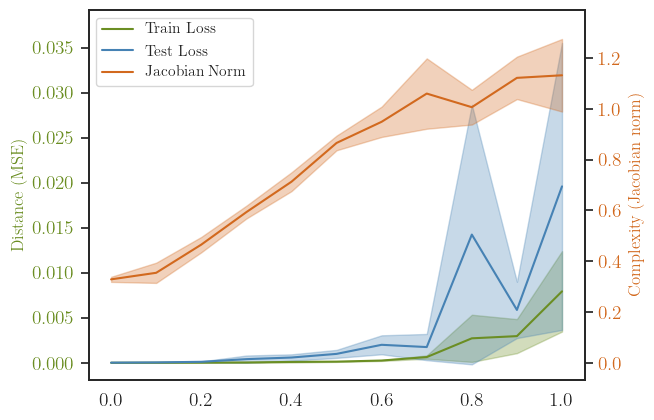

In [98]:
fig, ax1 = plt.subplots()
value_name = "interpol_value"
jac_norm_color = '#D2691E'
train_color = '#6B8E23'
test_color = '#4682B4'
point_alpha = 0.5
plot_error_scale = "linear"
# Group by x and compute stats across rs
grouped = df_all.groupby('interpol_value')['train_loss']
mean_loss = grouped.mean()
std_loss = grouped.std()  # or use min/max
ax1.plot(mean_loss.index, mean_loss.values, '-', color=train_color, label='Train Loss')
ax1.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=train_color, alpha=0.3)

grouped = df_all.groupby('interpol_value')['test_loss']
mean_loss = grouped.mean()
std_loss = grouped.std()  # or use min/max
ax1.plot(mean_loss.index, mean_loss.values, '-', color=test_color, label='Test Loss')
ax1.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=test_color, alpha=0.3)

grouped = df_all.groupby('interpol_value')['jac_norm_frobenius']
mean_loss = grouped.mean().astype(float)
std_loss = grouped.std().astype(float)
ax2 = ax1.twinx()
ax2.plot(mean_loss.index, mean_loss.values, '-', color=jac_norm_color, label='Jacobian Norm')
ax2.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=jac_norm_color, alpha=0.3)
# Combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

ax1.set_ylabel('Distance (MSE)', color=train_color)
ax1.tick_params(axis='y', labelcolor=train_color)

ax2.set_ylabel('Complexity (Jacobian norm)', color=jac_norm_color)
ax2.tick_params(axis='y', labelcolor=jac_norm_color)

ax1.set_ylim(-0.05*ax1.get_ylim()[1], ax1.get_ylim()[1] * 1.05)  # Add some space above the max value
ax2.set_ylim(-0.05*ax2.get_ylim()[1], ax2.get_ylim()[1] * 1.05)  # Add some space above the max value

plt.savefig(f"{save_dir_homeo}/losses_and_jacobian_norms_runs.pdf", dpi=300, bbox_inches='tight')
plt.show()


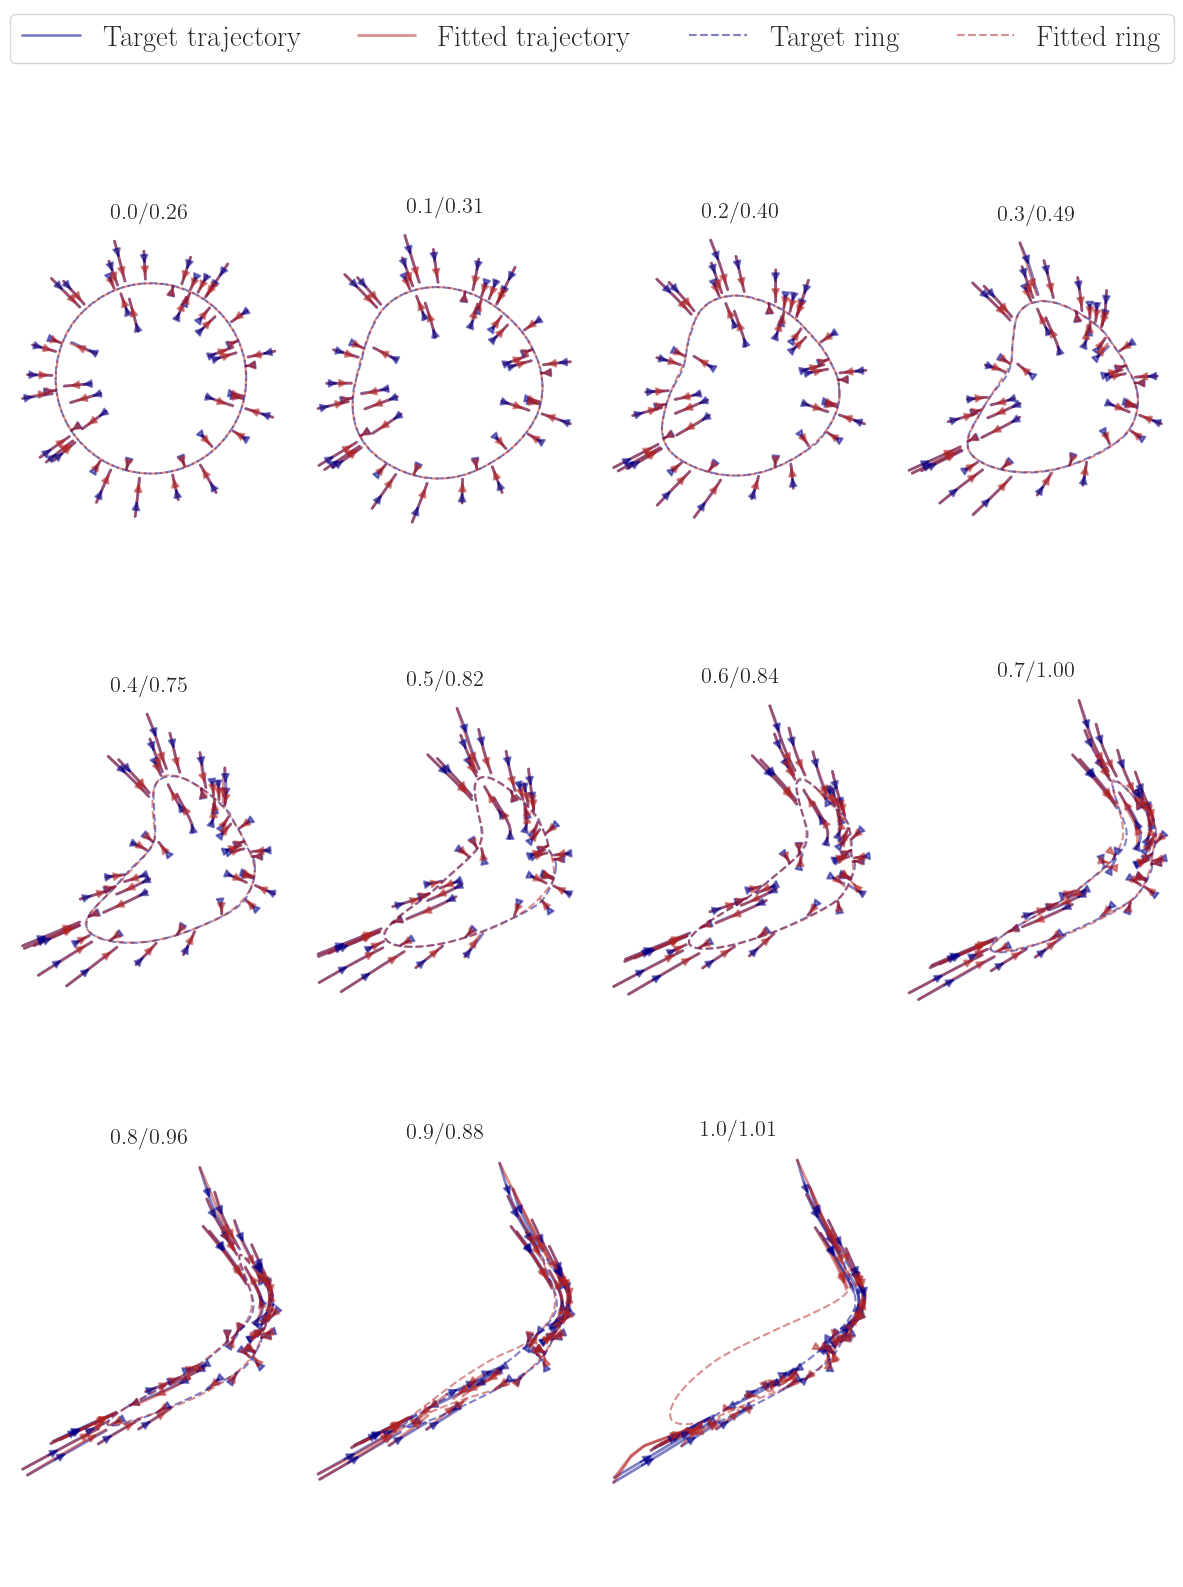

In [73]:
# Select the last 9 entries
targ_color='darkblue'
fit_color='firebrick'
alpha=0.5
last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(12, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    trajectories_target = np.load(f"experiments/homeopert_ring/trajectories_target_{row.interpol_value}.npy")
    for traj in trajectories_target:
        #ax.plot(traj[:, 0], traj[:, 1], color=targ_color, alpha=alpha)
        mid_idx = int(len(traj) * 0.1)
        #print(mid_idx)
        if mid_idx + 1 < len(traj):
            x_start, y_start = traj[mid_idx]
            x_end, y_end = traj[mid_idx + 1]
            dx = x_end - x_start
            dy = y_end - y_start
            ax.annotate(
                '',
                xy=(x_end, y_end),
                xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle='-|>', color=targ_color, lw=1.5, alpha=0.5),
            )
    l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, '-', color=targ_color, lw=2, alpha=0.5, label='Target trajectory')
    traj_trans_np = np.load(f"{save_dir_homeo}/traj_motif_transformed_{row.interpol_value}.npy") 
    l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, '-', color=fit_color, lw=2, alpha=0.5, label='Fitted trajectory')
    for traj in traj_trans_np:
        #ax.plot(traj[:, 0], traj[:, 1], color=fit_color, alpha=alpha)
        mid_idx = int(len(traj) * 0.5)
        #print(mid_idx)
        if mid_idx + 1 < len(traj):
            x_start, y_start = traj[mid_idx]
            x_end, y_end = traj[mid_idx + 1]
            dx = x_end - x_start
            dy = y_end - y_start
            ax.annotate(
                '',
                xy=(x_end, y_end),
                xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle='-|>', color=fit_color, lw=1.5, alpha=0.5),
            )

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color=targ_color, label='Target RA', alpha=0.5)
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '--', color=fit_color, label='Fitted RA', alpha=0.5)

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l1[0], l2[0], l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.interpol_value:.1f}/{row.jacobian_norm:.2f}", fontsize=16)
    ax.set_aspect('equal')
    ax.axis('off')

axes[-1].axis('off')  
# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=4, fontsize='xx-large', )

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir_homeo}/both_trajectories_asy.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [104]:
#load data
save_dir_pertvf_sra = "experiments/vf_pert_ring/simple/ring/"
df = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df.pkl")

save_dir_homeo = "experiments/homeopert_ring/ring"
#df0 = pd.read_hdf(f"{save_dir_pertvf_sra}/summary_df_rs0.h5", key='df')
df0 = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df_rs0.pkl")
df0['rs'] = 0

#df1 = pd.read_hdf(f"{save_dir_pertvf_sra}/summary_df_rs10.h5", key='df')
df1 = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df_rs10.pkl")
df1['rs'] = 10

#df2 = pd.read_hdf(f"{save_dir_pertvf_sra}/summary_df_rs20.h5", key='df')
df2 = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df_rs20.pkl")
df2['rs'] = 20

#df3 = pd.read_hdf(f"{save_dir_pertvf_sra}/summary_df_rs100.h5", key='df')
df3 = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df_rs100.pkl")
df3['rs'] = 100

df4 = pd.read_pickle(f"{save_dir_pertvf_sra}/summary_df_rs200.pkl")
df4['rs'] = 200

df_all = pd.concat([df1, df2, df3, df4], ignore_index=True)

df = df_all

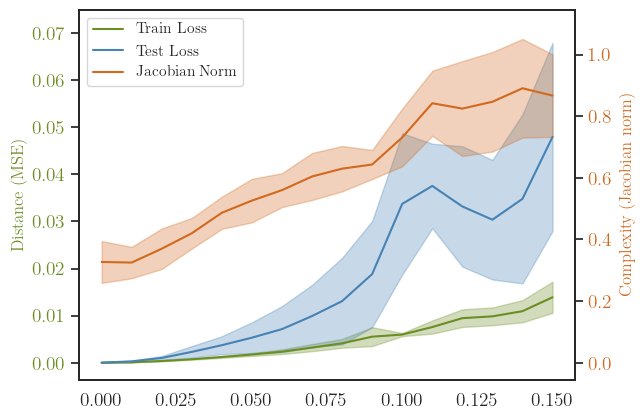

In [105]:
# plot_losses_and_jacobian_norms(df, value_name='p_norm', save_dir=save_dir_pertvf_sra, save_name='jacobian_norms_error.pdf')

fig, ax1 = plt.subplots()
value_name = "interpol_value"
jac_norm_color = '#D2691E'
train_color = '#6B8E23'
test_color = '#4682B4'
point_alpha = 0.5
plot_error_scale = "linear"
# Group by x and compute stats across rs
grouped = df_all.groupby('p_norm')['train_loss']
mean_loss = grouped.mean()
std_loss = grouped.std()  # or use min/max
ax1.plot(mean_loss.index, mean_loss.values, '-', color=train_color, label='Train Loss')
ax1.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=train_color, alpha=0.3)

grouped = df_all.groupby('p_norm')['test_loss']
mean_loss = grouped.mean()
std_loss = grouped.std()  # or use min/max
ax1.plot(mean_loss.index, mean_loss.values, '-', color=test_color, label='Test Loss')
ax1.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=test_color, alpha=0.3)

grouped = df_all.groupby('p_norm')['jac_norm_frobenius']
mean_loss = grouped.mean().astype(float)
std_loss = grouped.std().astype(float)
ax2 = ax1.twinx()
ax2.plot(mean_loss.index, mean_loss.values, '-', color=jac_norm_color, label='Jacobian Norm')
ax2.fill_between(mean_loss.index, 
                 mean_loss - std_loss, 
                 mean_loss + std_loss, 
                 color=jac_norm_color, alpha=0.3)
# Combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

ax1.set_ylabel('Distance (MSE)', color=train_color)
ax1.tick_params(axis='y', labelcolor=train_color)

ax2.set_ylabel('Complexity (Jacobian norm)', color=jac_norm_color)
ax2.tick_params(axis='y', labelcolor=jac_norm_color)

ax1.set_ylim(-0.05*ax1.get_ylim()[1], ax1.get_ylim()[1] * 1.05)  # Add some space above the max value
ax2.set_ylim(-0.05*ax2.get_ylim()[1], ax2.get_ylim()[1] * 1.05)  # Add some space above the max value

plt.savefig(f"{save_dir_pertvf_sra}/losses_and_jacobian_norms_runs.pdf", dpi=300, bbox_inches='tight')
plt.show()


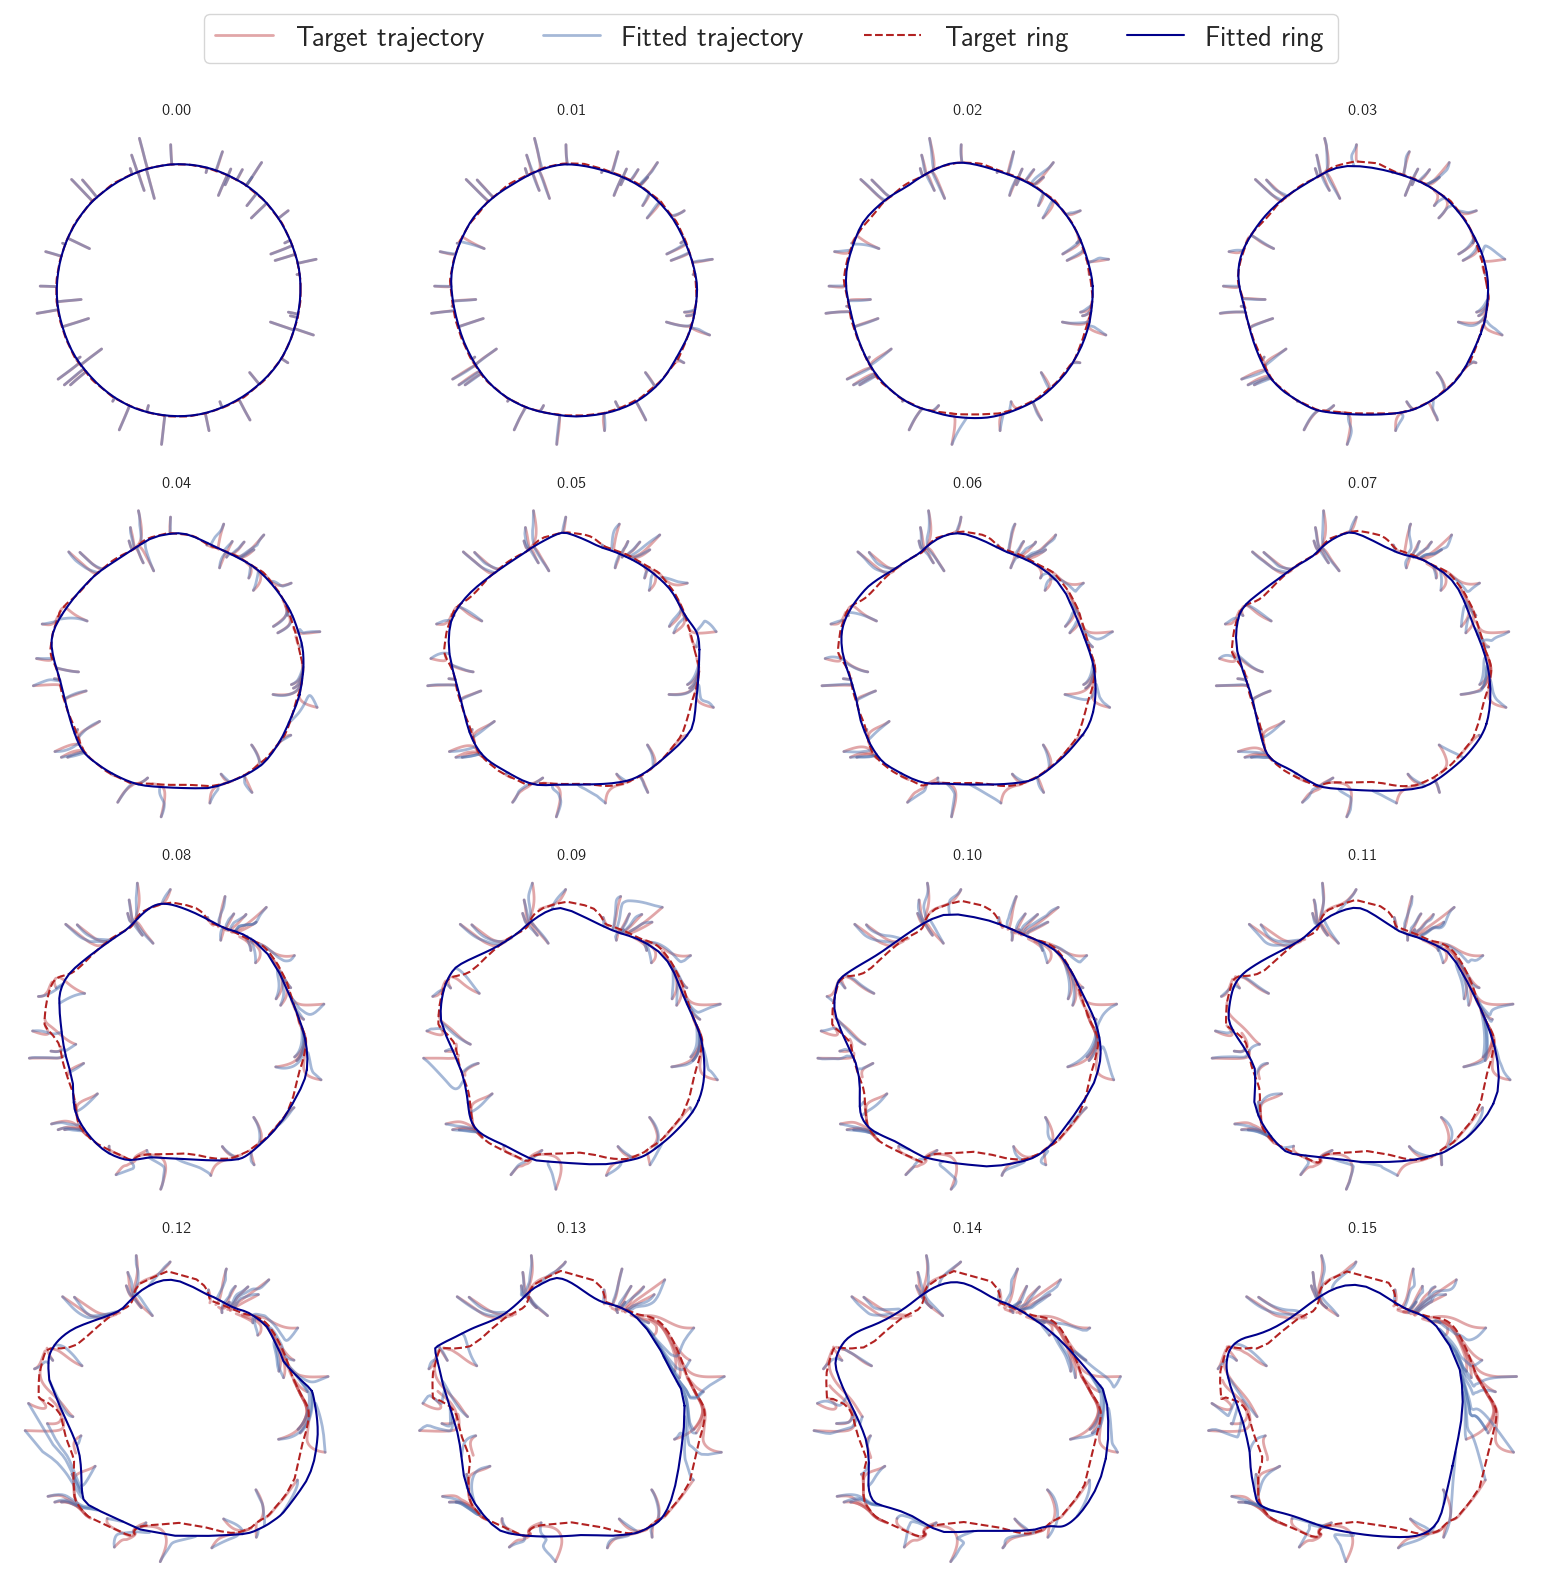

In [39]:
# Select the last 9 entries
last_rows = df.reset_index(drop=True)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

# For collecting handles and labels
legend_handles = []
legend_labels = []

for i, (ax, row) in enumerate(zip(axes, last_rows.iterrows())):
    row = row[1]  # iterrows() gives (index, row)

    trajectories_target = np.load(f"{save_dir_pertvf_sra}/trajectories_target_{row.p_norm}.npy")
    l1 = ax.plot(trajectories_target[:, :, 0].T, trajectories_target[:, :, 1].T, 'r-', lw=2, alpha=0.5, label='Target trajectory')
    traj_trans_np = np.load(f"{save_dir_pertvf_sra}/traj_motif_transformed_{row.p_norm}.npy") 
    l2 = ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, 'b-', lw=2, alpha=0.5, label='Fitted trajectory')

    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    l3 = ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='firebrick', label='Target RA')
    l4 = ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '-', color='darkblue', label='Fitted RA')

    # Collect legend handles from first plot only
    if i == 0:
        legend_handles.extend([l1[0], l2[0], l3[0], l4[0]])
        legend_labels.extend(['Target trajectory', 'Fitted trajectory', 'Target ring', 'Fitted ring'])

    ax.set_title(f"{row.p_norm:.2f}")
    ax.set_aspect('equal')
    ax.axis('off')

# Add a single global legend
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=4, fontsize='xx-large')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"{save_dir_pertvf_sra}/both_trajectories_asy.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [75]:

def plot_vector_field_fixedquivernorm_speedcontour(
    X, Y, U, V, trajectories_pertring,
    traj_trans_np=None,
    fit_ra_points=None,
    target_ra_points=None,
    title=None,
    background_color='white',
    scale=1.0,
    color='teal',
    cmap='plasma',
    traj_color='k',
    figsize=(6, 6),
    alpha=0.5,
    min_val_plot=1.25,
    vmin_log=-6,
    vmax_log=4,
    level_step=1,
    smoothing_sigma=1.0,
    upsample_factor=8,
    draw_arrows=True,
    save_name=None
):
    """
    Plot a vector field with scaled arrows and log-speed contours at fixed increments.

    Parameters:
        X, Y          : 2D meshgrid arrays for coordinates
        U, V          : 2D arrays for vector components at (X, Y)
        trajectories_pertring : array of shape (N_traj, T, 2) for plotting trajectories
        title         : plot title
        background_color : 'white' or 'black'
        scale         : global scaling factor for arrow sizes (currently unused)
        color         : not used (reserved for future vector coloring)
        cmap          : colormap for log-speed contours
        traj_color    : color for trajectory lines
        figsize       : figure size tuple
        alpha         : transparency for trajectory lines
        min_val_plot  : plot limits (xlim and ylim)
        vmin_log, vmax_log : bounds for log-speed color levels
        level_step    : interval between contour levels (e.g., 1 for integer steps)
        smoothing_sigma : standard deviation for optional Gaussian smoothing
        upsample_factor : factor to interpolate data grid for smoother contour plot
    """
    # Compute speed and log-speed
    speed = np.sqrt(U**2 + V**2)
    log_speed = speed
    log_speed = np.log10(speed + 1e-8)

    # Scale vector magnitude radially
    R = np.sqrt(X**2 + Y**2)
    scale_factor = radial_scale(R)
    # U_scaled = U * scale_factor
    # V_scaled = V * scale_factor

    # Normalize vectors for uniform arrow lengths
    U_unit = U / (speed + 1e-8)
    V_unit = V / (speed + 1e-8)

    # Interpolate log speed to finer grid
    x_fine = np.linspace(X.min(), X.max(), X.shape[1] * upsample_factor)
    y_fine = np.linspace(Y.min(), Y.max(), Y.shape[0] * upsample_factor)
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

    log_speed_fine = griddata(
        (X.flatten(), Y.flatten()),
        log_speed.flatten(),
        (X_fine, Y_fine),
        method='cubic',
        fill_value=np.nan
    )
    log_speed_fine = gaussian_filter(log_speed_fine, sigma=smoothing_sigma)
    log_speed_fine = np.clip(log_speed_fine, vmin_log, vmax_log)

    # Define discrete contour levels
    levels = np.arange(vmin_log, vmax_log + level_step, level_step)

    # Set up figure and axis
    font_color = 'white' if background_color == 'black' else 'black'
    plt.rcParams['axes.facecolor'] = background_color
    plt.rcParams['figure.facecolor'] = background_color
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.set_facecolor(background_color)
    if title:
        ax.set_title(title, color=font_color)

    # Filled contour plot of log-speed
    contour = ax.contourf(
        X_fine, Y_fine, log_speed_fine,
        levels=levels,
        cmap=cmap,
        alpha=0.8
    )

    # Colorbar formatting
    cbar = plt.colorbar(contour, ax=ax, shrink=0.75)
    cbar.set_label('log speed', color=font_color)
    cbar.ax.yaxis.set_tick_params(color=font_color)
    plt.setp(cbar.ax.get_yticklabels(), color=font_color)

    # Quiver plot of normalized vectors
    ax.quiver(X, Y, U_unit, V_unit, color=font_color, scale=30)

    # Plot trajectories
    for traj in trajectories_pertring:
        ax.plot(traj[:, 0], traj[:, 1], color=traj_color, alpha=alpha)
        if draw_arrows:
                    # Add arrow in the middle
            mid_idx = int(len(traj) * 0.1)
            #print(mid_idx)
            if mid_idx + 1 < len(traj):
                x_start, y_start = traj[mid_idx]
                x_end, y_end = traj[mid_idx + 1]               
                ax.annotate(
                    '',
                    xy=(x_end, y_end),
                    xytext=(x_start, y_start),
                    arrowprops=dict(arrowstyle='-|>', color=traj_color, lw=1.5, alpha=0.5),
                )

    if traj_trans_np is not None:
        ax.plot(traj_trans_np[:, :, 0].T, traj_trans_np[:, :, 1].T, '-', color='firebrick', lw=2, alpha=0.5, label='Fitted trajectory')
        if draw_arrows:
            for traj in traj_trans_np:
                mid_idx = int(len(traj) * 0.5)
                #print(mid_idx)
                if mid_idx + 1 < len(traj):
                    x_start, y_start = traj[mid_idx]
                    x_end, y_end = traj[mid_idx + 1]               
                    ax.annotate(
                        '',
                        xy=(x_end, y_end),
                        xytext=(x_start, y_start),
                        arrowprops=dict(arrowstyle='-|>', color='firebrick', lw=1.5, alpha=0.5))
    if fit_ra_points is not None:
        ax.plot(fit_ra_points[:, 0], fit_ra_points[:, 1], '-', color='firebrick', label='Fitted RA', alpha=0.5)
    if target_ra_points is not None:
        ax.plot(target_ra_points[:, 0], target_ra_points[:, 1], '--', color='darkblue', label='Target RA', alpha=0.5)
    ax.set_xlim(-min_val_plot, min_val_plot)
    ax.set_ylim(-min_val_plot, min_val_plot)
    ax.set_xticks([])
    ax.set_yticks([])

    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    plt.show()


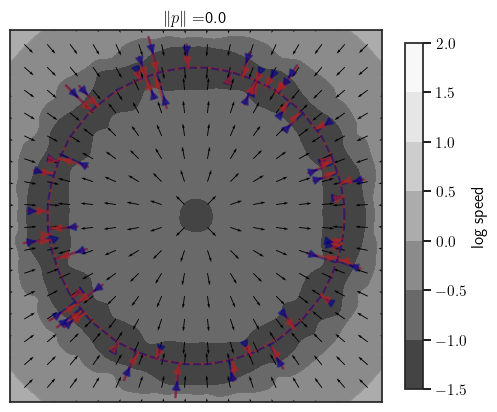

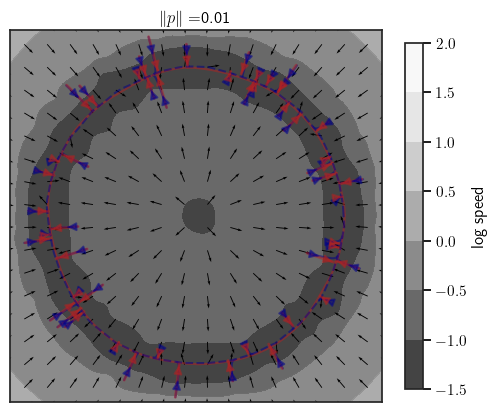

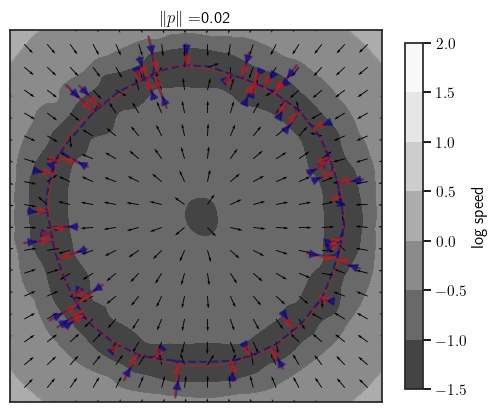

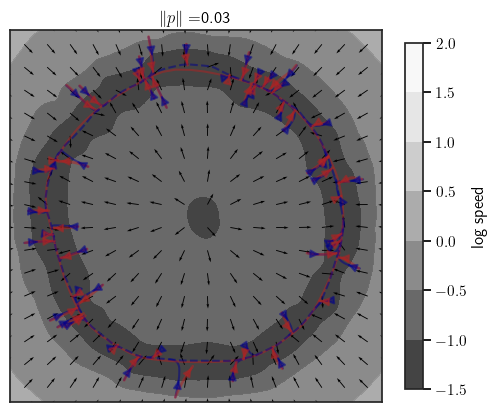

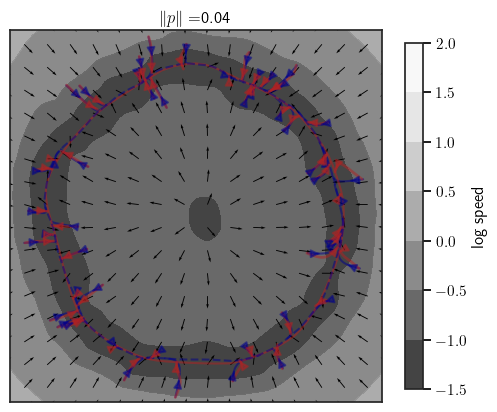

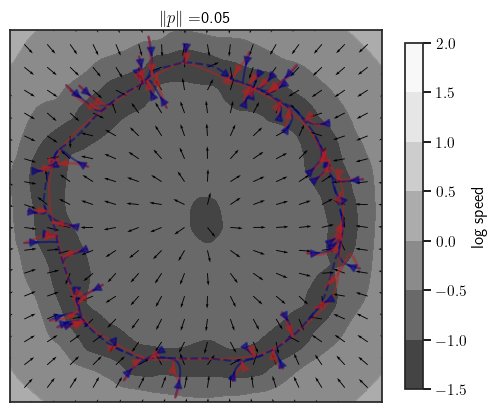

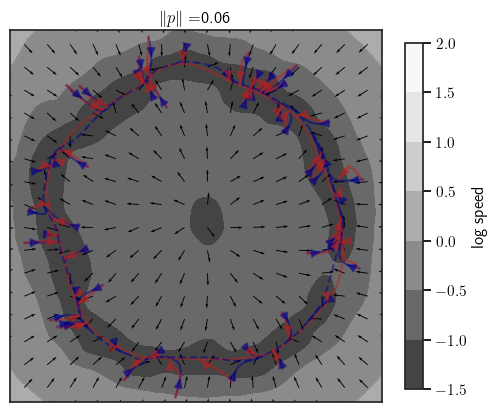

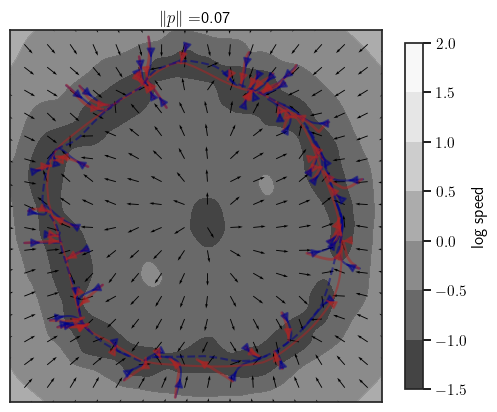

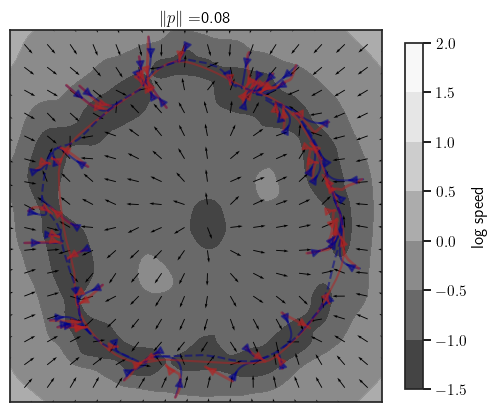

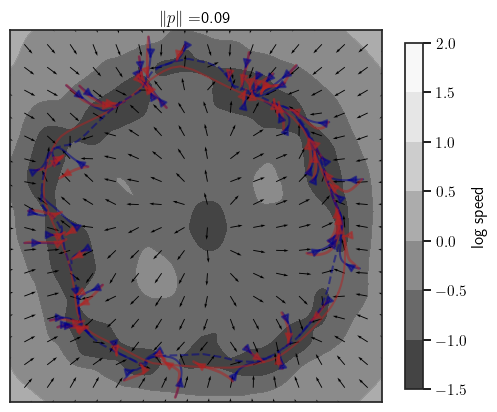

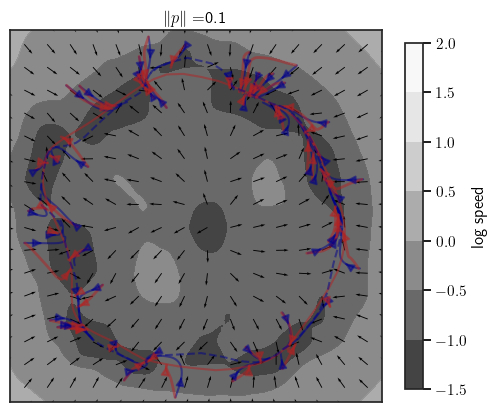

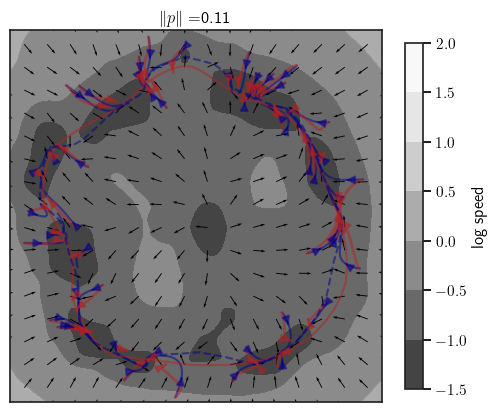

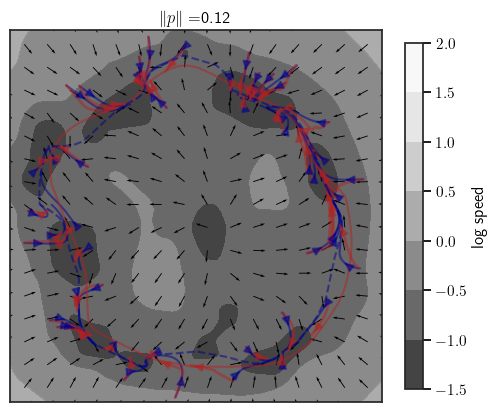

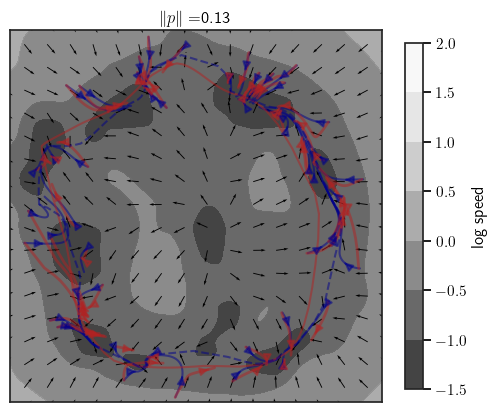

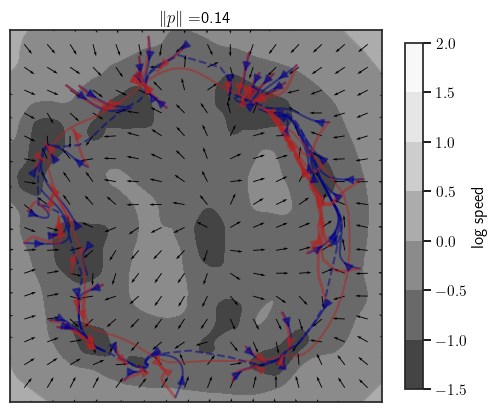

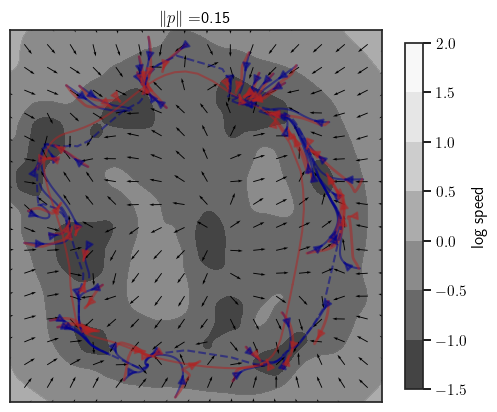

In [76]:
dim = 2
maxT = 5
tsteps = maxT*20
max_perturbation_norm = .15
pring_simulation_params = {"maxT": maxT, "tsteps": tsteps, "perturbation_norm": 0.01, "random_seed": 313, "min_val_sim": 3, "n_grid": 40, "add_limit_cycle": False, "num_points_invman": 20,
                            "number_of_target_trajectories": 50, "initial_conditions_mode": "random", "init_margin": 0.25}
save_dir = 'experiments/vf_pert_ring/vfs/'
for p_norm in np.arange(0.0, max_perturbation_norm + 0.001, 0.01):
    pring_simulation_params['perturbation_norm'] = p_norm
    X, Y, U_pert, V_pert, grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_man, trajectories_pertring = build_perturbed_ringattractor(**pring_simulation_params) 
    U = X * (1- np.sqrt(X**2 + Y**2))
    V = Y * (1- np.sqrt(X**2 + Y**2))

    #trajectories_target = np.load(f"{save_dir_pertvf_sra}/trajectories_target_{row.p_norm}.npy")
    trajectories_target = torch.tensor(trajectories_pertring, dtype=torch.float32)
    trajectories_target_full, trajectories_target, mean, std = normalize_scale_pair(trajectories_target, False)
    traj_trans_np = np.load(f"{save_dir_pertvf_sra}/traj_motif_transformed_{row.p_norm}.npy") 
    traj_trans_np = traj_trans_np* std.detach().numpy() + mean.detach().numpy()

    row = df[df['p_norm'] == p_norm].iloc[0]
    fit_ra_points = row['fit_ra_points']
    target_ra_points = row['target_ra_points']
    fit_ra_points = (fit_ra_points ) * std.detach().numpy()+ mean.detach().numpy()
    target_ra_points = (target_ra_points ) * std.detach().numpy() + mean.detach().numpy()
    plot_vector_field_fixedquivernorm_speedcontour(X, Y, U_pert, V_pert, trajectories_pertring, traj_trans_np=traj_trans_np,
                                                   fit_ra_points=fit_ra_points[0], target_ra_points=target_ra_points[0],
                                                    title=f"$\|p\|=${p_norm}", scale=1.0, color='teal', alpha=0.5, cmap='Greys_r', traj_color='darkblue', background_color='white', min_val_plot=1.25,
                                                vmin_log=-1.5, vmax_log=2, level_step=.5,
                                                save_name=f"{save_dir}/vf_pring_{p_norm}.pdf")